
ENHANCED PAYMENTS FRAUD DETECTION SYSTEM
LOADING AND EXPLORING DATA
📂 Reading data from: /users/marco/Downloads/fraud_data.csv
✅ Dataset randomly sampled to 300000 rows

📊 Dataset Overview
Shape: (300000, 11)

First 5 rows:
    step      type      amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0   278   CASH_IN   330218.42   C632336343       20866.00       351084.42   
1    15   PAYMENT    11647.08  C1264712553       30370.00        18722.92   
2    10   CASH_IN   152264.21  C1746846248      106589.00       258853.21   
3   403  TRANSFER  1551760.63   C333676753           0.00            0.00   
4   206   CASH_IN    78172.30   C813403091     2921331.58      2999503.88   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0   C834976624       452419.57       122201.15        0               0  
1   M215391829            0.00            0.00        0               0  
2  C1607284477       201303.01        49038.80        0               0  
3  C1564353608 

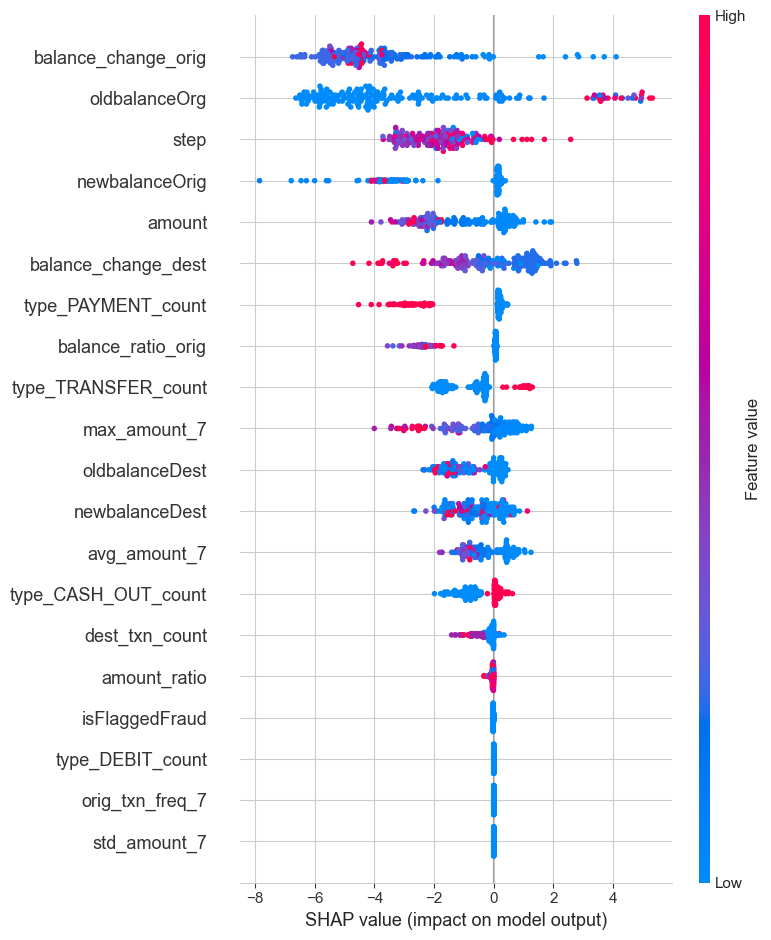

✅ SHAP summary saved: outputs_fraud_project\shap_summary_XGBoost.png

CREATING VISUALIZATIONS


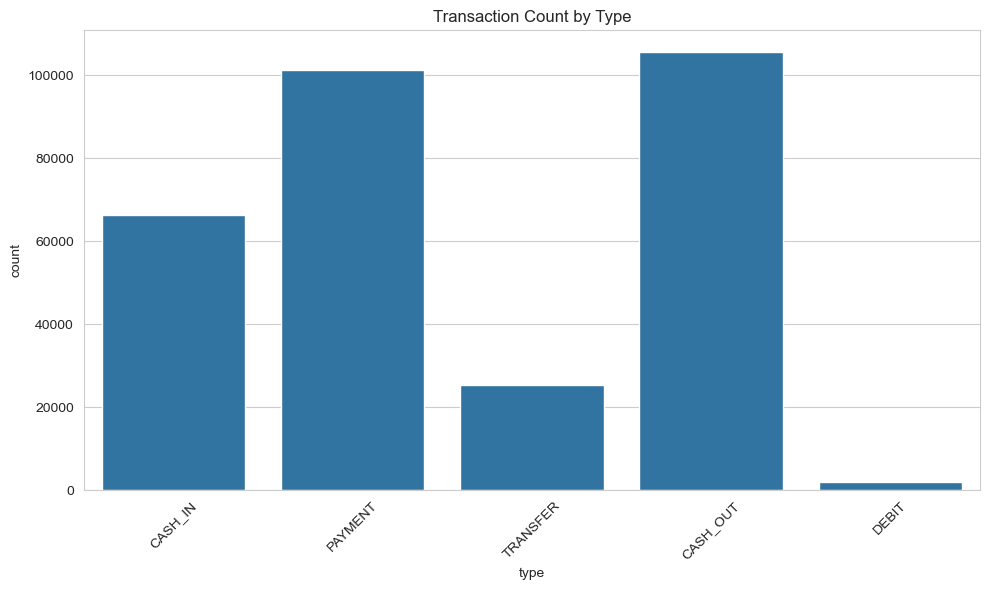

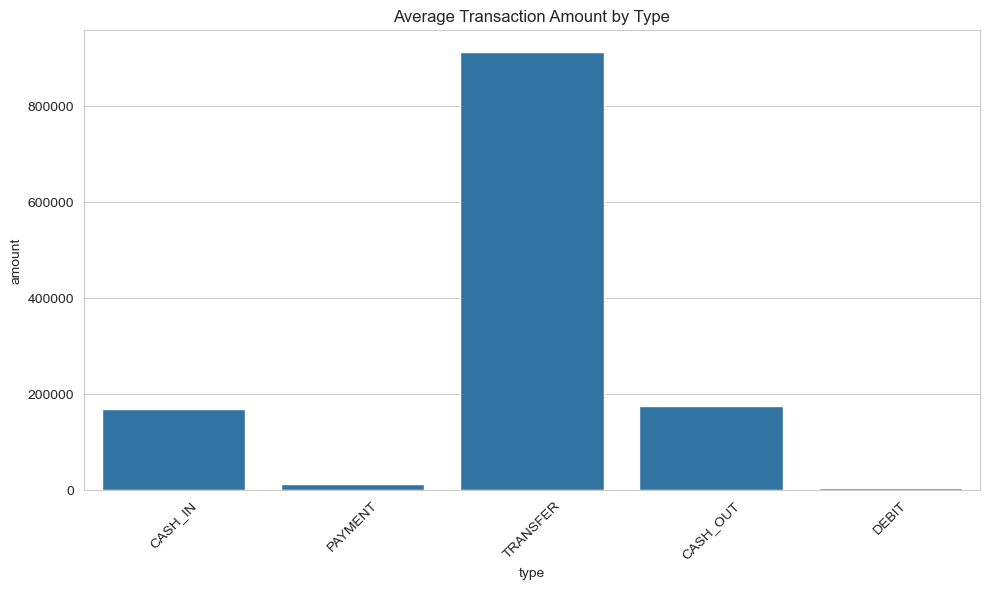

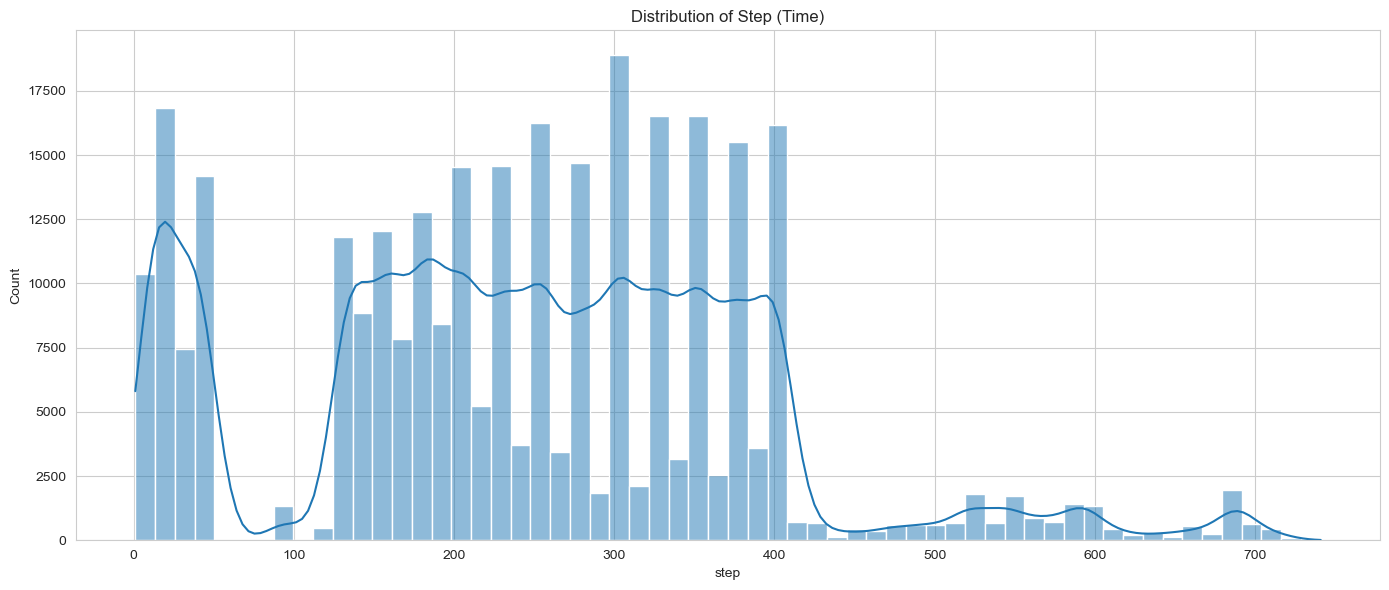

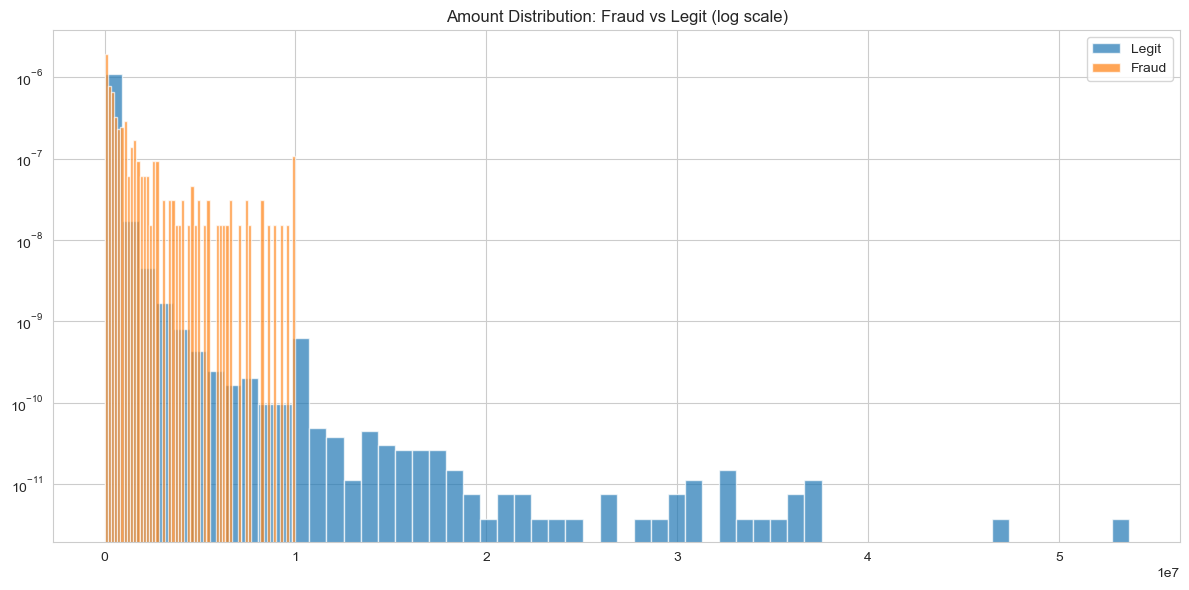

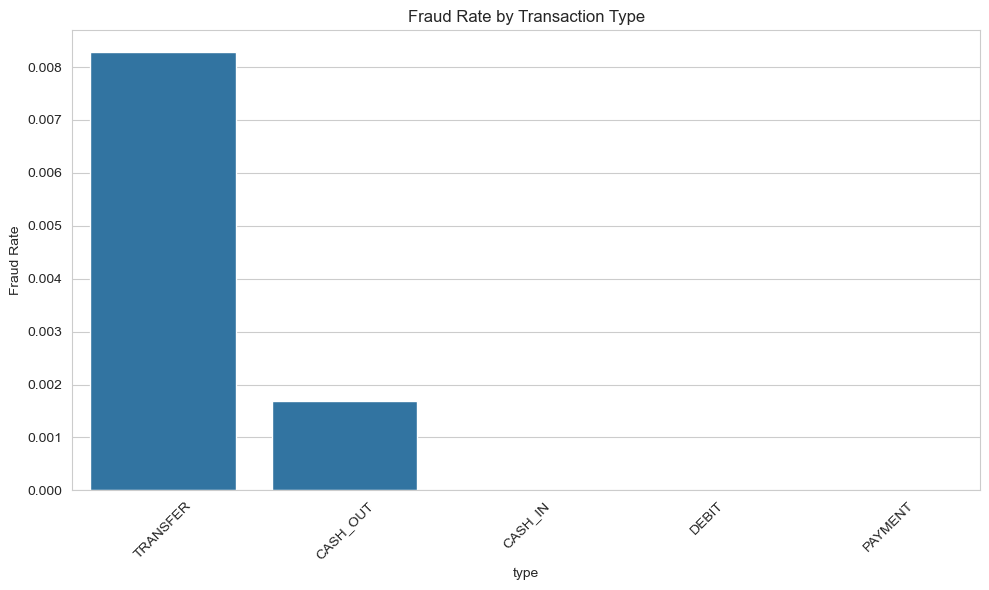

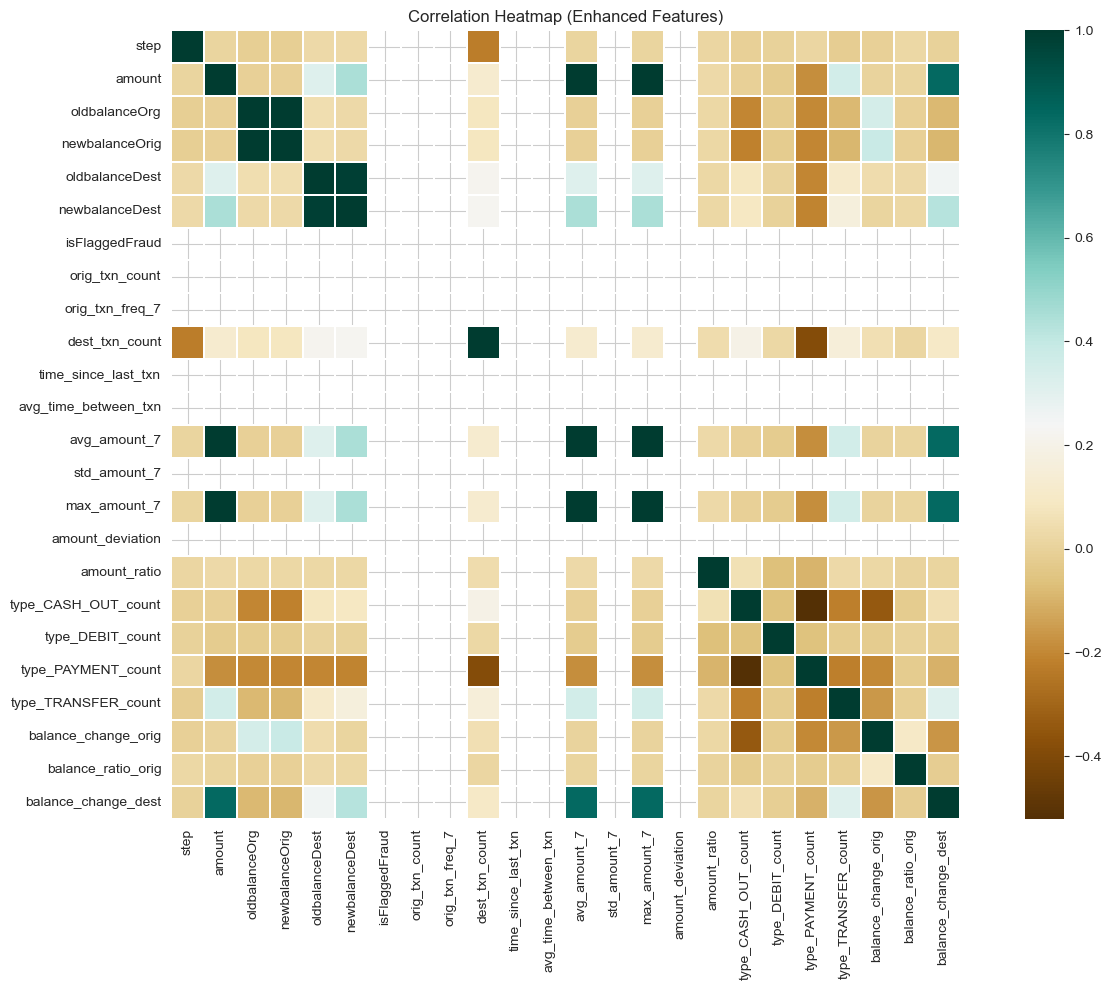

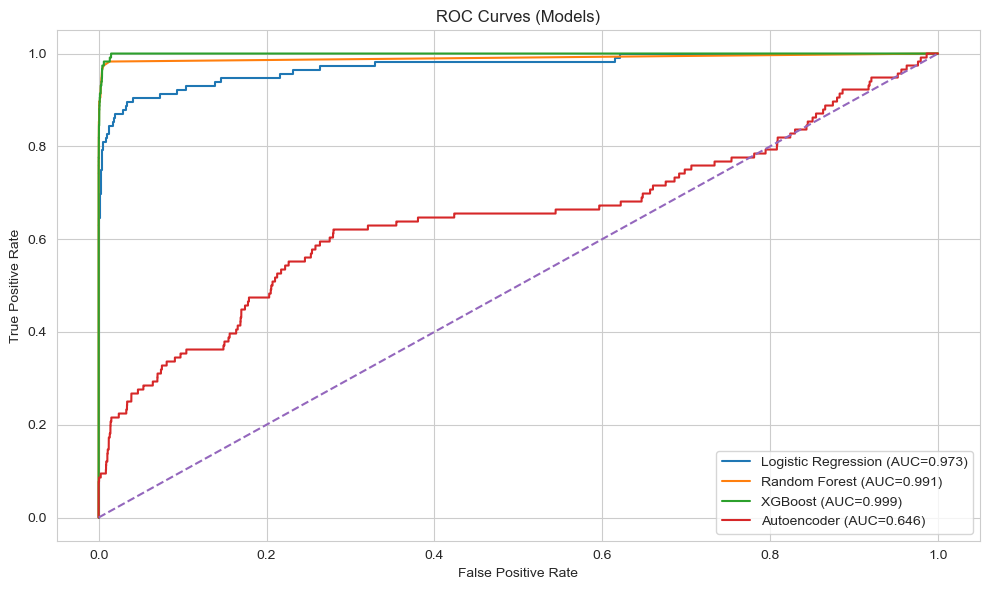

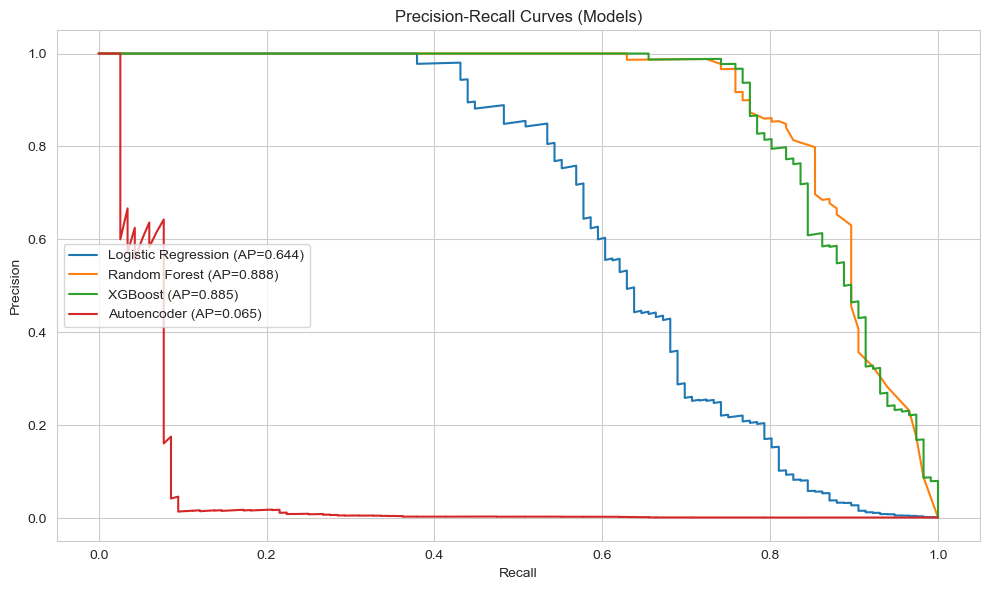

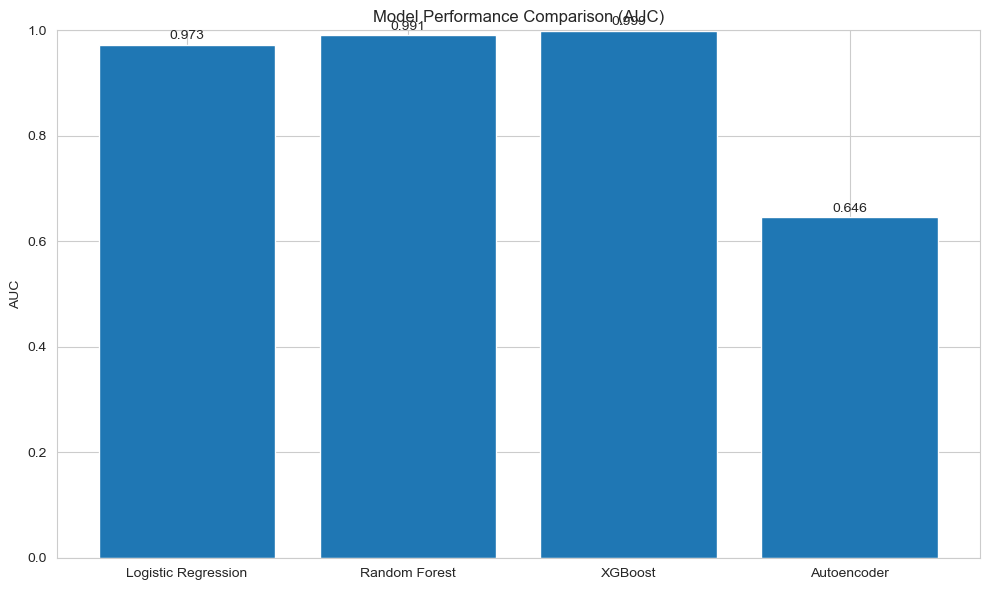

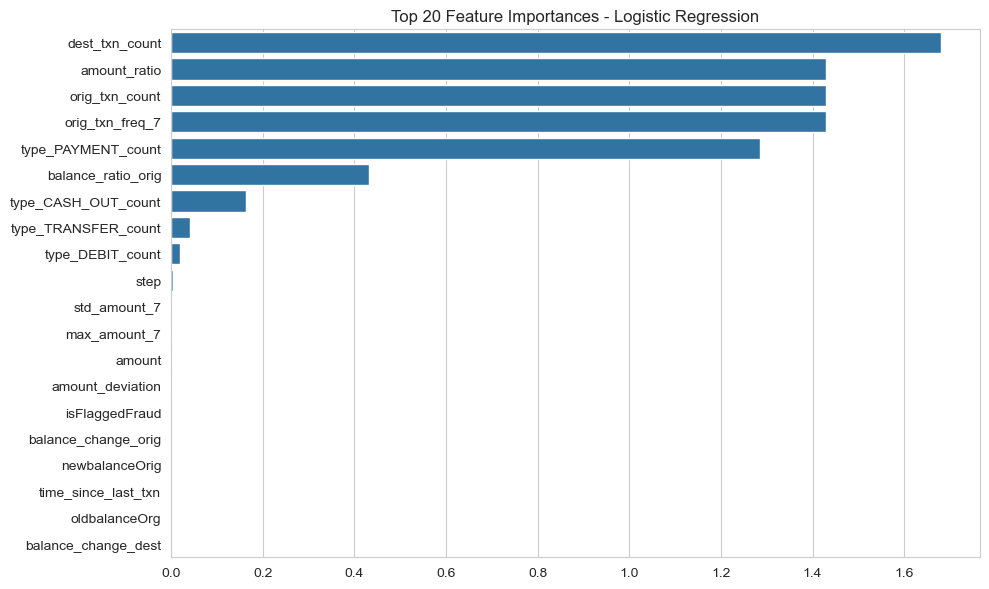

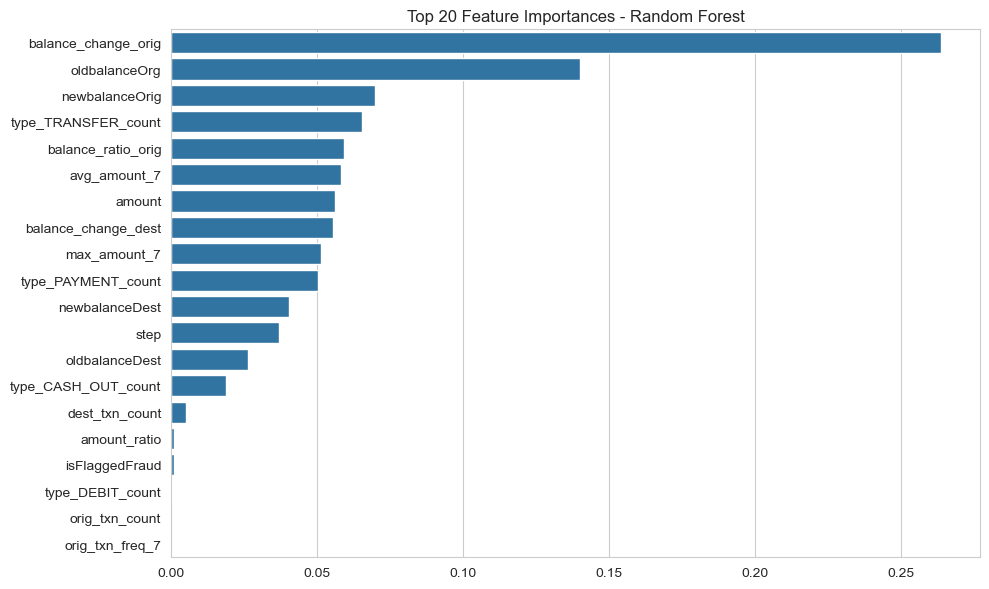

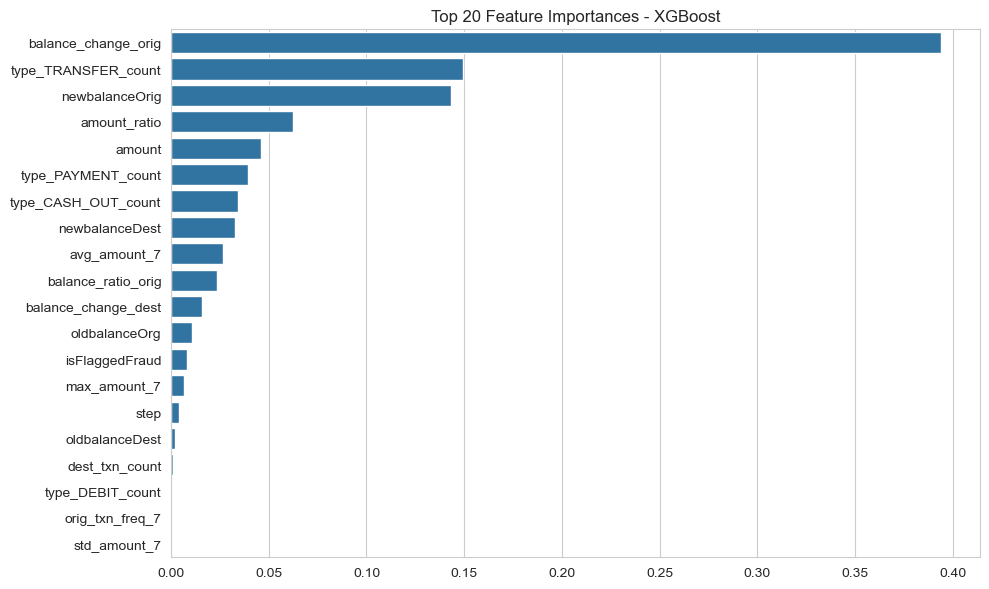

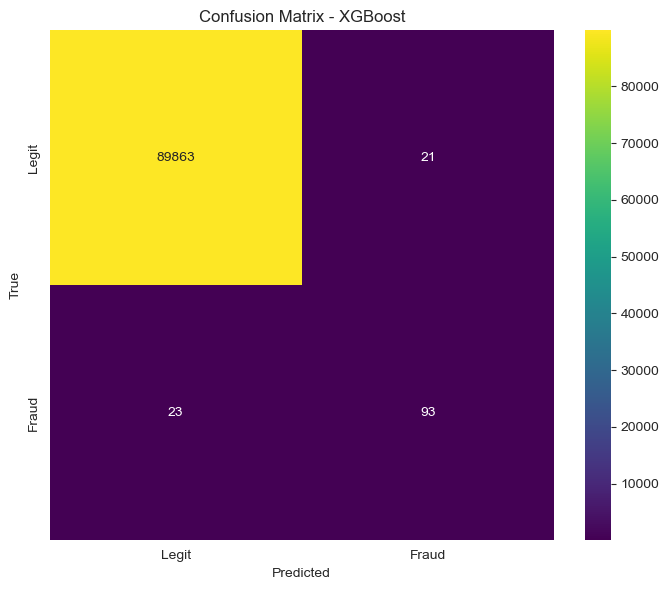


Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9998     89884
           1     0.8158    0.8017    0.8087       116

    accuracy                         0.9995     90000
   macro avg     0.9078    0.9007    0.9042     90000
weighted avg     0.9995    0.9995    0.9995     90000


✅ Metadata saved: outputs_fraud_project\run_metadata.json

ANALYSIS COMPLETE!


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime

# -------------------- Deep Learning --------------------
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# -------------------- Preprocessing --------------------
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# -------------------- Traditional ML --------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    precision_recall_curve, roc_curve, average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# -------------------- XAI --------------------
import shap

# -------------------- Optional XGBoost --------------------
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False

# -------------------- Plot style --------------------
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# ============================================================================
# 0. CONFIG (safe toggles so your notebook doesn’t “freeze”)
# ============================================================================

CONFIG = {
    # File path
    "file_path": "/users/marco/Downloads/fraud_data.csv",

    # Sampling
    "sample_size": 300000,         # keep your original; lower to 50_000 for dev
    "random_state": 42,

    # Train split
    "test_size": 0.30,

    # Traditional model toggles
    "run_logreg": True,
    "run_rf": True,
    "run_xgb": True,               # will auto-disable if not installed

    # Deep learning toggles
    "run_lstm": True,
    "run_autoencoder": True,

    # LSTM sequence config
    "sequence_length": 10,
    "lstm_feature_cap": 20,        # use first N numeric features for LSTM (keeps it stable)
    "lstm_epochs": 10,
    "lstm_batch_size": 64,

    # Autoencoder config
    "ae_epochs": 20,

    # SHAP toggles
    "run_shap": True,
    "shap_max_rows": 200,          # safe cap so it doesn't hang
    "shap_model_whitelist": ["XGBoost", "Random Forest"],

    # Output folder
    "output_dir": "outputs_fraud_project"
}

os.makedirs(CONFIG["output_dir"], exist_ok=True)

# ============================================================================
# 1. DATA LOADING AND EXPLORATION
# ============================================================================

def load_and_explore_data(file_path, sample_size=300000, random_state=42):
    print("=" * 60)
    print("LOADING AND EXPLORING DATA")
    print("=" * 60)

    print(f"📂 Reading data from: {file_path}")
    data = pd.read_csv(file_path)

    if len(data) > sample_size:
        data = data.sample(n=sample_size, random_state=random_state).reset_index(drop=True)
        print(f"✅ Dataset randomly sampled to {sample_size} rows")

    if "step" in data.columns:
        data["step"] = pd.to_numeric(data["step"], errors="coerce").fillna(0)

    print("\n📊 Dataset Overview")
    print(f"Shape: {data.shape}")
    print("\nFirst 5 rows:\n", data.head())

    print("\nData Info:")
    data.info()

    print("\nStatistical Summary (numeric):")
    print(data.describe())

    obj = (data.dtypes == "object")
    object_cols = list(obj[obj].index)
    print(f"\nCategorical variables: {len(object_cols)}")
    print(object_cols)

    print("\n🎯 Fraud Distribution:")
    if "isFraud" in data.columns:
        fraud_counts = data["isFraud"].value_counts(dropna=False)
        print(fraud_counts)
        if 1 in fraud_counts.index:
            print(f"\nFraud Rate: {fraud_counts[1] / len(data) * 100:.4f}%")
    else:
        raise ValueError("Column 'isFraud' not found in dataset.")

    return data

# ============================================================================
# 2. FEATURE ENGINEERING (Behavioral Features)
# ============================================================================

def create_behavioral_features(data):
    """
    Create behavioral features:
    - Frequency (counts)
    - Velocity (time deltas + rolling means)
    - Amount patterns (rolling stats)
    - Type patterns (one-hot + type counts)
    - Balance deltas/ratios
    """
    print("\n" + "=" * 60)
    print("CREATING BEHAVIORAL FEATURES")
    print("=" * 60)

    df = data.copy()

    # Sort by time if available
    if "step" in df.columns:
        df = df.sort_values("step").reset_index(drop=True)

    # -------------------- Frequency --------------------
    print("📈 Frequency features...")
    if "nameOrig" in df.columns:
        orig_counts = df.groupby("nameOrig").size()
        df["orig_txn_count"] = df["nameOrig"].map(orig_counts)

        # Rolling txn count per account (window=7)
        # NOTE: This can be expensive on huge data. Keep but fillna.
        df["orig_txn_freq_7"] = df.groupby("nameOrig")["step"].transform(
            lambda x: x.rolling(window=7, min_periods=1).count()
        )

    if "nameDest" in df.columns:
        dest_counts = df.groupby("nameDest").size()
        df["dest_txn_count"] = df["nameDest"].map(dest_counts)

    # -------------------- Velocity --------------------
    print("⚡ Velocity features...")
    if "nameOrig" in df.columns and "step" in df.columns:
        df["time_since_last_txn"] = df.groupby("nameOrig")["step"].diff().fillna(0)

        df["avg_time_between_txn"] = df.groupby("nameOrig")["time_since_last_txn"].transform(
            lambda x: x.rolling(window=5, min_periods=1).mean()
        )

    # -------------------- Amount patterns --------------------
    print("💰 Amount pattern features...")
    if "amount" in df.columns:
        if "nameOrig" in df.columns:
            df["avg_amount_7"] = df.groupby("nameOrig")["amount"].transform(
                lambda x: x.rolling(window=7, min_periods=1).mean()
            )
            df["std_amount_7"] = df.groupby("nameOrig")["amount"].transform(
                lambda x: x.rolling(window=7, min_periods=1).std()
            )
            df["max_amount_7"] = df.groupby("nameOrig")["amount"].transform(
                lambda x: x.rolling(window=7, min_periods=1).max()
            )

        fallback_mean = df["amount"].mean()
        ref_avg = df["avg_amount_7"] if "avg_amount_7" in df.columns else fallback_mean
        df["amount_deviation"] = df["amount"] - ref_avg
        df["amount_ratio"] = df["amount"] / (ref_avg + 1e-6)

    # -------------------- Transaction type patterns --------------------
    print("🔄 Type features...")
    if "type" in df.columns:
        type_dummies = pd.get_dummies(df["type"], prefix="type", drop_first=True)
        df = pd.concat([df, type_dummies], axis=1)

        if "nameOrig" in df.columns:
            for col in type_dummies.columns:
                df[f"{col}_count"] = df.groupby("nameOrig")[col].transform("sum")

    # -------------------- Balance-based features --------------------
    print("🏦 Balance features...")
    if {"oldbalanceOrg", "newbalanceOrig"}.issubset(df.columns):
        df["balance_change_orig"] = df["newbalanceOrig"] - df["oldbalanceOrg"]
        df["balance_ratio_orig"] = df["newbalanceOrig"] / (df["oldbalanceOrg"] + 1e-6)

    if {"oldbalanceDest", "newbalanceDest"}.issubset(df.columns):
        df["balance_change_dest"] = df["newbalanceDest"] - df["oldbalanceDest"]

    df = df.fillna(0)

    print(f"\n✅ Enhanced dataset shape: {df.shape}")
    print(f"   Original features: {len(data.columns)}")
    print(f"   New features: {len(df.columns) - len(data.columns)}")
    return df

# ============================================================================
# 3. PYTORCH DATASET + MODELS
# ============================================================================

class TransactionDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.FloatTensor(sequences)
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

class LSTMFraudDetector(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc1 = nn.Linear(hidden_size, 32)
        self.fc2 = nn.Linear(32, 1)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        x = self.drop(last)
        x = torch.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return torch.sigmoid(x)

class AutoencoderFraudDetector(nn.Module):
    def __init__(self, input_size, encoding_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# ============================================================================
# 3B. SEQUENCE CREATION (FIXED SAFELY)
# ============================================================================

def create_sequences(data, sequence_length=10, feature_cols=None):
    """
    Create LSTM sequences grouped by nameOrig, ordered by step.
    Fix: robust sorting (avoid group.index.name None issues).
    """
    if feature_cols is None:
        feature_cols = [c for c in data.columns if c not in ["isFraud", "nameOrig", "nameDest", "type"]]

    sequences, labels = [], []

    if "nameOrig" in data.columns:
        for _, group in data.groupby("nameOrig", sort=False):
            if "step" in group.columns:
                group = group.sort_values("step")
            else:
                group = group.sort_index()

            feats = group[feature_cols].values
            ys = group["isFraud"].values

            if len(group) < sequence_length:
                continue

            for i in range(len(group) - sequence_length + 1):
                sequences.append(feats[i:i + sequence_length])
                labels.append(ys[i + sequence_length - 1])
    else:
        # fallback
        if "step" in data.columns:
            data = data.sort_values("step")
        feats = data[feature_cols].values
        ys = data["isFraud"].values
        for i in range(len(data) - sequence_length + 1):
            sequences.append(feats[i:i + sequence_length])
            labels.append(ys[i + sequence_length - 1])

    return np.array(sequences), np.array(labels)

# ============================================================================
# 3C. TRAIN LSTM
# ============================================================================

def train_lstm_model(X_train_seq, y_train_seq, X_test_seq, y_test_seq, input_size, epochs=10, batch_size=64):
    print("\n" + "=" * 60)
    print("TRAINING LSTM MODEL")
    print("=" * 60)

    train_ds = TransactionDataset(X_train_seq, y_train_seq)
    test_ds = TransactionDataset(X_test_seq, y_test_seq)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMFraudDetector(input_size=input_size).to(device)

    crit = nn.BCELoss()
    opt = torch.optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(epochs):
        total = 0.0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            opt.zero_grad()
            preds = model(xb).squeeze()
            loss = crit(preds, yb)
            loss.backward()
            opt.step()
            total += loss.item()

        if (epoch + 1) % max(1, epochs // 5) == 0:
            print(f"Epoch {epoch+1}/{epochs} | Loss: {total/len(train_loader):.4f}")

    model.eval()
    all_preds = []
    with torch.no_grad():
        for xb, _ in test_loader:
            xb = xb.to(device)
            preds = model(xb).squeeze().detach().cpu().numpy()
            all_preds.extend(np.atleast_1d(preds))

    all_preds = np.array(all_preds)
    auc = roc_auc_score(y_test_seq[:len(all_preds)], all_preds) if len(np.unique(y_test_seq)) > 1 else np.nan
    print(f"✅ LSTM Test AUC: {auc:.4f}" if auc == auc else "✅ LSTM Test AUC: NA (single-class labels)")

    return model, all_preds, y_test_seq[:len(all_preds)]

# ============================================================================
# 3D. TRAIN AUTOENCODER
# ============================================================================

def train_autoencoder_model(X_train, y_train, X_test, y_test, input_size, epochs=20):
    print("\n" + "=" * 60)
    print("TRAINING AUTOENCODER MODEL")
    print("=" * 60)

    legit_mask = (y_train == 0)
    X_train_legit = X_train[legit_mask]

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_legit)
    X_test_scaled = scaler.transform(X_test)

    train_tensor = torch.FloatTensor(X_train_scaled)
    test_tensor = torch.FloatTensor(X_test_scaled)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AutoencoderFraudDetector(input_size=input_size).to(device)

    crit = nn.MSELoss()
    opt = torch.optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(epochs):
        opt.zero_grad()
        out = model(train_tensor.to(device))
        loss = crit(out, train_tensor.to(device))
        loss.backward()
        opt.step()

        if (epoch + 1) % max(1, epochs // 5) == 0:
            print(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        recon = model(test_tensor.to(device)).cpu()
        errs = torch.mean((test_tensor - recon) ** 2, dim=1).numpy()

    scores = errs / (errs.max() + 1e-6)
    auc = roc_auc_score(y_test, scores) if len(np.unique(y_test)) > 1 else np.nan
    print(f"✅ Autoencoder Test AUC: {auc:.4f}" if auc == auc else "✅ Autoencoder Test AUC: NA (single-class labels)")

    return model, scores, y_test, scaler

# ============================================================================
# 4. TRADITIONAL ML MODELS
# ============================================================================

def train_traditional_models(X_train, y_train, X_test, y_test):
    print("\n" + "=" * 60)
    print("TRAINING TRADITIONAL ML MODELS")
    print("=" * 60)

    models = {}
    if CONFIG["run_logreg"]:
        models["Logistic Regression"] = LogisticRegression(max_iter=1000, random_state=CONFIG["random_state"])

    if CONFIG["run_rf"]:
        models["Random Forest"] = RandomForestClassifier(
            n_estimators=200,
            criterion="entropy",
            random_state=CONFIG["random_state"],
            class_weight="balanced"
        )

    if CONFIG["run_xgb"]:
        if XGBOOST_AVAILABLE:
            models["XGBoost"] = XGBClassifier(
                eval_metric="logloss",
                random_state=CONFIG["random_state"],
                scale_pos_weight=len(y_train[y_train == 0]) / max(1, len(y_train[y_train == 1]))
            )
        else:
            print("⚠️ XGBoost not installed. Skipping XGBoost.")
            CONFIG["run_xgb"] = False

    results = {}
    for name, model in models.items():
        print(f"\n🔧 Training {name}...")
        model.fit(X_train, y_train)

        # Some models might not have predict_proba; your chosen ones do.
        train_preds = model.predict_proba(X_train)[:, 1]
        test_preds = model.predict_proba(X_test)[:, 1]

        train_auc = roc_auc_score(y_train, train_preds) if len(np.unique(y_train)) > 1 else np.nan
        test_auc = roc_auc_score(y_test, test_preds) if len(np.unique(y_test)) > 1 else np.nan

        results[name] = {
            "model": model,
            "train_auc": train_auc,
            "test_auc": test_auc,
            "test_preds": test_preds,
            "y_test": y_test.values if hasattr(y_test, "values") else y_test
        }

        if train_auc == train_auc:
            print(f"  Training AUC: {train_auc:.4f}")
        else:
            print("  Training AUC: NA (single-class labels)")

        if test_auc == test_auc:
            print(f"  Test AUC:     {test_auc:.4f}")
        else:
            print("  Test AUC:     NA (single-class labels)")

    return results

# ============================================================================
# 5. XAI - SHAP (SAFE)
# ============================================================================

def explain_model_with_shap(model, X_sample_df, model_name):
    """
    SHAP can be heavy; we cap the number of rows and only run for tree models by default.
    """
    print("\n" + "=" * 60)
    print(f"GENERATING SHAP EXPLANATIONS ({model_name})")
    print("=" * 60)

    if len(X_sample_df) == 0:
        print("⚠️ Empty sample for SHAP.")
        return None, None

    # cap sample size
    n = min(CONFIG["shap_max_rows"], len(X_sample_df))
    X_small = X_sample_df.sample(n=n, random_state=CONFIG["random_state"])

    try:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_small)

        # summary plot
        plt.figure()
        shap.summary_plot(shap_values, X_small, show=False)
        outpath = os.path.join(CONFIG["output_dir"], f"shap_summary_{model_name}.png")
        plt.tight_layout()
        plt.savefig(outpath, dpi=300, bbox_inches="tight")
        plt.show()
        print(f"✅ SHAP summary saved: {outpath}")

        return explainer, shap_values
    except Exception as e:
        print(f"⚠️ SHAP failed: {e}")
        return None, None

# ============================================================================
# 6. VISUALIZATIONS (Expanded)
# ============================================================================

def savefig(name):
    return os.path.join(CONFIG["output_dir"], name)

def plot_transaction_type_counts(data):
    if "type" not in data.columns:
        return
    plt.figure(figsize=(10, 6))
    sns.countplot(x="type", data=data)
    plt.title("Transaction Count by Type")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(savefig("transaction_count_by_type.png"), dpi=300, bbox_inches="tight")
    plt.show()

def plot_avg_amount_by_type(data):
    if "type" not in data.columns or "amount" not in data.columns:
        return
    plt.figure(figsize=(10, 6))
    sns.barplot(x="type", y="amount", data=data, estimator=np.mean, errorbar=None)
    plt.title("Average Transaction Amount by Type")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(savefig("avg_amount_by_type.png"), dpi=300, bbox_inches="tight")
    plt.show()

def plot_step_distribution(data):
    if "step" not in data.columns:
        return
    plt.figure(figsize=(14, 6))
    sns.histplot(data["step"], bins=60, kde=True)
    plt.title("Distribution of Step (Time)")
    plt.tight_layout()
    plt.savefig(savefig("step_distribution.png"), dpi=300, bbox_inches="tight")
    plt.show()

def plot_amount_distribution_by_fraud(data):
    if "amount" not in data.columns or "isFraud" not in data.columns:
        return
    fraud = data.loc[data["isFraud"] == 1, "amount"]
    legit = data.loc[data["isFraud"] == 0, "amount"]

    plt.figure(figsize=(12, 6))
    plt.hist(legit, bins=60, alpha=0.7, label="Legit", density=True)
    plt.hist(fraud, bins=60, alpha=0.7, label="Fraud", density=True)
    plt.yscale("log")
    plt.legend()
    plt.title("Amount Distribution: Fraud vs Legit (log scale)")
    plt.tight_layout()
    plt.savefig(savefig("amount_distribution_fraud_vs_legit.png"), dpi=300, bbox_inches="tight")
    plt.show()

def plot_fraud_rate_by_type(data):
    if "type" not in data.columns or "isFraud" not in data.columns:
        return
    plt.figure(figsize=(10, 6))
    rates = data.groupby("type")["isFraud"].mean().sort_values(ascending=False)
    sns.barplot(x=rates.index, y=rates.values, errorbar=None)
    plt.title("Fraud Rate by Transaction Type")
    plt.ylabel("Fraud Rate")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(savefig("fraud_rate_by_type.png"), dpi=300, bbox_inches="tight")
    plt.show()

def plot_correlation_heatmap(data_enhanced):
    numeric_cols = data_enhanced.select_dtypes(include=[np.number]).columns
    numeric_cols = [c for c in numeric_cols if c != "isFraud"]
    if len(numeric_cols) < 2:
        return

    sample_n = min(10000, len(data_enhanced))
    corr_df = data_enhanced[numeric_cols].sample(sample_n, random_state=CONFIG["random_state"])

    plt.figure(figsize=(14, 10))
    corr = corr_df.corr()
    sns.heatmap(corr, cmap="BrBG", annot=False, square=True, linewidths=0.3)
    plt.title("Correlation Heatmap (Enhanced Features)")
    plt.tight_layout()
    plt.savefig(savefig("correlation_heatmap.png"), dpi=300, bbox_inches="tight")
    plt.show()

def plot_roc_pr_curves(results_dict):
    """
    Plot ROC + PR curves for any models that provide predictions aligned with their y_test.
    """
    plt.figure(figsize=(10, 6))
    any_plotted = False

    for name, res in results_dict.items():
        y_true = np.array(res["y_test"])
        y_score = np.array(res["test_preds"])

        if len(np.unique(y_true)) < 2:
            continue

        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc = roc_auc_score(y_true, y_score)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
        any_plotted = True

    if any_plotted:
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.title("ROC Curves (Models)")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.tight_layout()
        plt.savefig(savefig("roc_curves.png"), dpi=300, bbox_inches="tight")
        plt.show()

    # PR curve
    plt.figure(figsize=(10, 6))
    any_plotted = False
    for name, res in results_dict.items():
        y_true = np.array(res["y_test"])
        y_score = np.array(res["test_preds"])

        if len(np.unique(y_true)) < 2:
            continue

        prec, rec, _ = precision_recall_curve(y_true, y_score)
        ap = average_precision_score(y_true, y_score)
        plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")
        any_plotted = True

    if any_plotted:
        plt.title("Precision-Recall Curves (Models)")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend()
        plt.tight_layout()
        plt.savefig(savefig("pr_curves.png"), dpi=300, bbox_inches="tight")
        plt.show()

def plot_model_comparison(model_results):
    names = []
    aucs = []
    for name, res in model_results.items():
        if "test_auc" in res and res["test_auc"] == res["test_auc"]:
            names.append(name)
            aucs.append(res["test_auc"])

    if len(names) == 0:
        return

    plt.figure(figsize=(10, 6))
    bars = plt.bar(names, aucs)
    plt.title("Model Performance Comparison (AUC)")
    plt.ylabel("AUC")
    plt.ylim(0, 1)

    for b, a in zip(bars, aucs):
        plt.text(b.get_x() + b.get_width()/2, b.get_height() + 0.01, f"{a:.3f}", ha="center")

    plt.tight_layout()
    plt.savefig(savefig("model_comparison_auc.png"), dpi=300, bbox_inches="tight")
    plt.show()

def plot_confusion_matrix(y_true, y_score, title):
    """
    Confusion matrix for predictions aligned with y_true.
    """
    y_pred = (y_score > 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis",
                xticklabels=["Legit", "Fraud"], yticklabels=["Legit", "Fraud"])
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(savefig(f"confusion_matrix_{title.replace(' ', '_')}.png"), dpi=300, bbox_inches="tight")
    plt.show()

def plot_feature_importance(model, feature_names, title):
    """
    Feature importance plot for tree models (RF / XGB). Safe if attribute exists.
    """
    imp = None
    if hasattr(model, "feature_importances_"):
        imp = model.feature_importances_
    elif hasattr(model, "coef_"):
        # Logistic Regression: use absolute coefficient values
        imp = np.abs(model.coef_).ravel()

    if imp is None:
        return

    order = np.argsort(imp)[::-1][:20]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=imp[order], y=np.array(feature_names)[order], errorbar=None)
    plt.title(f"Top 20 Feature Importances - {title}")
    plt.tight_layout()
    plt.savefig(savefig(f"feature_importance_{title.replace(' ', '_')}.png"), dpi=300, bbox_inches="tight")
    plt.show()

def create_visualizations(data, data_enhanced, model_results):
    print("\n" + "=" * 60)
    print("CREATING VISUALIZATIONS")
    print("=" * 60)

    # EDA
    plot_transaction_type_counts(data)
    plot_avg_amount_by_type(data)
    plot_step_distribution(data)
    plot_amount_distribution_by_fraud(data)
    plot_fraud_rate_by_type(data)

    # Correlation
    plot_correlation_heatmap(data_enhanced)

    # Model curves + comparison
    plot_roc_pr_curves(model_results)
    plot_model_comparison(model_results)

    # Feature importance for eligible models
    for name, res in model_results.items():
        m = res.get("model", None)
        if m is None:
            continue
        if hasattr(m, "feature_importances_") or hasattr(m, "coef_"):
            plot_feature_importance(m, res.get("feature_names", []), name)

# ============================================================================
# 7. MAIN EXECUTION (FIXED)
# ============================================================================

def main():
    print("\n" + "=" * 80)
    print("ENHANCED PAYMENTS FRAUD DETECTION SYSTEM")
    print("=" * 80)

    file_path = CONFIG["file_path"]

    # 1) Load
    data = load_and_explore_data(
        file_path=file_path,
        sample_size=CONFIG["sample_size"],
        random_state=CONFIG["random_state"]
    )

    # 2) Features
    data_enhanced = create_behavioral_features(data)

    # 3) Prepare model matrix
    exclude_cols = ["isFraud", "nameOrig", "nameDest"]
    if "type" in data_enhanced.columns:
        exclude_cols.append("type")

    X = data_enhanced.drop(columns=exclude_cols, errors="ignore")
    X = X.select_dtypes(include=[np.number]).copy()
    y = data_enhanced["isFraud"].astype(int).copy()

    print("\n📊 Final Feature Set:")
    print(f"   Features: {X.shape[1]}")
    print(f"   Samples:  {X.shape[0]}")
    print(f"   Example features: {list(X.columns[:10])} ...")

    # 4) Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=CONFIG["test_size"],
        random_state=CONFIG["random_state"],
        stratify=y
    )

    print(f"\n📦 Train: {len(X_train)} | Test: {len(X_test)}")
    model_results = {}

    # 5) Traditional ML
    trad_results = train_traditional_models(X_train, y_train, X_test, y_test)

    # attach feature_names for plots
    for k, v in trad_results.items():
        v["feature_names"] = list(X.columns)
        model_results[k] = v

    # 6) Deep learning (kept, fixed alignment)
    # NOTE: LSTM uses sequences; its y_test is y_test_seq, not y_test
    if CONFIG["run_lstm"]:
        try:
            print("\n🔄 Preparing sequences for LSTM (real grouping if available)...")
            feature_cols = list(X.columns[: min(CONFIG["lstm_feature_cap"], X.shape[1])])

            # Use ORIGINAL columns needed for grouping if available; otherwise fallback to simplified demo
            seq_df_train = data_enhanced.loc[X_train.index, ["isFraud", "step", "nameOrig"]].copy()
            seq_df_test  = data_enhanced.loc[X_test.index,  ["isFraud", "step", "nameOrig"]].copy()

            # Add numeric features
            for c in feature_cols:
                seq_df_train[c] = X_train[c].values
                seq_df_test[c]  = X_test[c].values

            # If nameOrig missing, fallback to making synthetic ids (but your dataset normally has it)
            if "nameOrig" not in seq_df_train.columns:
                seq_df_train["nameOrig"] = np.arange(len(seq_df_train))
                seq_df_test["nameOrig"]  = np.arange(len(seq_df_test))

            X_train_seq, y_train_seq = create_sequences(seq_df_train, CONFIG["sequence_length"], feature_cols)
            X_test_seq,  y_test_seq  = create_sequences(seq_df_test,  CONFIG["sequence_length"], feature_cols)

            if len(X_train_seq) > 0 and len(X_test_seq) > 0:
                lstm_model, lstm_preds, lstm_y_aligned = train_lstm_model(
                    X_train_seq, y_train_seq,
                    X_test_seq, y_test_seq,
                    input_size=len(feature_cols),
                    epochs=CONFIG["lstm_epochs"],
                    batch_size=CONFIG["lstm_batch_size"]
                )

                lstm_auc = roc_auc_score(lstm_y_aligned, lstm_preds) if len(np.unique(lstm_y_aligned)) > 1 else np.nan
                model_results["LSTM"] = {
                    "model": lstm_model,
                    "train_auc": np.nan,
                    "test_auc": lstm_auc,
                    "test_preds": lstm_preds,
                    "y_test": lstm_y_aligned,
                    "feature_names": feature_cols
                }
            else:
                print("⚠️ LSTM skipped: Not enough sequences created.")
        except Exception as e:
            print(f"⚠️ LSTM training skipped: {e}")

    if CONFIG["run_autoencoder"]:
        try:
            ae_model, ae_preds, ae_y_aligned, ae_scaler = train_autoencoder_model(
                X_train.values, y_train.values,
                X_test.values, y_test.values,
                input_size=X_train.shape[1],
                epochs=CONFIG["ae_epochs"]
            )
            ae_auc = roc_auc_score(ae_y_aligned, ae_preds) if len(np.unique(ae_y_aligned)) > 1 else np.nan
            model_results["Autoencoder"] = {
                "model": ae_model,
                "scaler": ae_scaler,
                "train_auc": np.nan,
                "test_auc": ae_auc,
                "test_preds": ae_preds,
                "y_test": ae_y_aligned,
                "feature_names": list(X.columns)
            }
        except Exception as e:
            print(f"⚠️ Autoencoder training skipped: {e}")

    # 7) Pick best model by AUC (ignore NaNs)
    best_name = None
    best_auc = -1

    for name, res in model_results.items():
        auc = res.get("test_auc", np.nan)
        if auc == auc and auc > best_auc:
            best_auc = auc
            best_name = name

    print("\n" + "=" * 60)
    if best_name is None:
        print("No best model selected (AUC unavailable).")
    else:
        print(f"🎯 Best Model: {best_name} (AUC: {best_auc:.4f})")
    print("=" * 60)

    # 8) SHAP (only for eligible tree models; safe cap)
    if CONFIG["run_shap"] and best_name in CONFIG["shap_model_whitelist"]:
        try:
            best_model = model_results[best_name]["model"]
            X_sample_df = X_test.copy()
            explain_model_with_shap(best_model, X_sample_df, best_name)
        except Exception as e:
            print(f"⚠️ SHAP skipped due to error: {e}")

    # 9) Visualizations (expanded)
    create_visualizations(data, data_enhanced, model_results)

    # 10) Confusion matrix for best model (FIXED: uses aligned y_test for each model)
    if best_name is not None:
        y_aligned = np.array(model_results[best_name]["y_test"])
        preds = np.array(model_results[best_name]["test_preds"])
        if len(y_aligned) == len(preds):
            plot_confusion_matrix(y_aligned, preds, best_name)
            print("\nClassification report (threshold=0.5):")
            print(classification_report(y_aligned, (preds > 0.5).astype(int), digits=4))
        else:
            print(f"⚠️ Confusion matrix skipped: y_true len={len(y_aligned)} != preds len={len(preds)}")

    # 11) Save metadata
    metadata = {
        "best_model": best_name,
        "best_auc": float(best_auc) if best_auc == best_auc else None,
        "feature_count": int(X.shape[1]),
        "sample_count": int(X.shape[0]),
        "timestamp": datetime.now().isoformat(),
        "xgboost_available": bool(XGBOOST_AVAILABLE),
        "config": CONFIG
    }

    meta_path = os.path.join(CONFIG["output_dir"], "run_metadata.json")
    try:
        import json
        with open(meta_path, "w") as f:
            json.dump(metadata, f, indent=2)
        print(f"\n✅ Metadata saved: {meta_path}")
    except Exception as e:
        print(f"⚠️ Could not save metadata: {e}")

    print("\n" + "=" * 80)
    print("ANALYSIS COMPLETE!")
    print("=" * 80)

    return model_results, data_enhanced

# ============================================================================
# EXECUTE (FIXED)
# ============================================================================
if __name__ == "__main__":
    results, enhanced_data = main()